## Epidemic-Behavior Interaction Model (EBIM)

[🔗 Notion Page](https://shengfu.notion.site/Epidemic-Behavior-Interaction-Model-EBIM-e456583642254fae92007c80f4944587?pvs=4)

In [609]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class Node: 

    def __init__(self, node_id, gamma, eta) -> None:
        """
        Initialize a Node with an ID and initial state.
        
        Args:
        - node_id (int): Unique identifier for the node.
        - state_awareness (int): 0 for unaware (U), 1 for aware (A).
        - state_disease (int): 0 for susceptible (S), 1 for infected (I).
        """

        self.id = node_id
        self.state_disease = 0
        self.state_awareness = 0

        self.new_state_disease = 0
        self.new_state_awareness = 0

        self.physical_neighbors = []
        self.virtual_neighbors = []

        # set aware therold as a random number between 0 and 1 following a uniform distribution
        self.aware_therold = np.random.uniform(0, 1)
        # self.aware_therold = np.random.uniform(0.05, 0.95)

        self.infected_time = -1

        self.gamma = gamma
        self.eta = eta

    def add_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.append(neighbor_node)
    
    def remove_physical_neighbor(self, neighbor_node):
        self.physical_neighbors.remove(neighbor_node)

    def add_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.append(neighbor_node)

    def remove_virtual_neighbor(self, neighbor_node):
        self.virtual_neighbors.remove(neighbor_node)

    def get_physical_neighbors_id(self):
        return [neighbors.id for neighbors in self.physical_neighbors]

    def get_virtual_neighbors_id(self):
        return [neighbors.id for neighbors in self.virtual_neighbors]

    def turn_into_aware(self):
        self.new_state_awareness = 1
        
    def turn_into_unaware(self):
        self.new_state_awareness = 0
        
    def turn_into_infectious(self, time: int):
        self.new_state_disease = 1
        self.infected_time = time

        # self.turn_into_aware() # If the node is infected, then turn into aware???

    def turn_into_susceptible(self):
        self.new_state_disease = 0
        self.infected_time = -1

    def update_to_new_state(self):
        self.state_disease = self.new_state_disease
        self.state_awareness = self.new_state_awareness

    def rewire(self, all_susceptible_nodes):
        for neighbor in random.sample(self.physical_neighbors, len(self.physical_neighbors)):
            # break the link with the infected neighbor at probability gamma
            if neighbor.state_disease == 1 and np.random.rand() < self.gamma:
                
                # rewire to a neighbor of a neighbor (nodes at distance 2) at probability eta
                if np.random.rand() < self.eta:
                    new_links_pool = set()
                    for n in self.physical_neighbors:
                        if n.id != neighbor.id:
                            new_links_pool.update(n.physical_neighbors) 
                    [new_links_pool.discard(n) for n in list(new_links_pool) if n.state_disease == 1] # remove the infected modes
                # rewire to random susceptible node at probability 1 - eta
                else:
                    new_links_pool = set(all_susceptible_nodes)
                
                new_links_pool = new_links_pool - set(self.physical_neighbors)
                new_links_pool.discard(self)
                # print(self.id, neighbor.id, [n.id for n in list(new_links_pool)], [n.id for n in all_susceptible_nodes])

                if len(new_links_pool) > 0:
                    new_neighbor = random.choice(list(new_links_pool))
                    self.add_physical_neighbor(new_neighbor)
                    new_neighbor.add_physical_neighbor(self)

                    self.remove_physical_neighbor(neighbor)
                    neighbor.remove_physical_neighbor(self)

                    return 1
        return 0

class TwoLayerNetwork:
    def __init__(self, N, k, beta_a, beta_u, alpha, infection_period, gamma, eta, overlap_percentage=1, initial_infected_ratio=0.05, intial_aware_ratio=0) -> None:
        """
        Initialize a two-layer network with N nodes in each layer.

        Args:
        - N (int): Number of nodes in each layer.
        - rewiring_percentage (float): Percentage of edges to rewire in the virtual network
        - beta_a (float): Transmission probability for aware nodes.
        - beta_u (float): Transmission probability for unaware nodes.
        - alpha (float): Probability of recovery.
        - infection_period (int): Duration of the infection period.
        - gamma (float): Probability of rewiring the physical network.
        - eta (float): Probability of rewiring to a neighbor of a neighbor.
        """
        # Create N nodes 
        self.nodes = [Node(node_id=i, gamma=gamma, eta=eta) for i in range(N)]

        # Infect a fraction of the nodes
        num_infected = int(initial_infected_ratio * N)
        infected_nodes = np.random.choice(self.nodes, num_infected, replace=False)
        for node in infected_nodes:
            node.turn_into_infectious(time=0)
        
        # Make a fraction of the nodes aware
        num_aware = int(intial_aware_ratio * N)
        aware_nodes = np.random.choice(self.nodes, num_aware, replace=False)
        for node in aware_nodes:
            node.turn_into_aware()

        for node in self.nodes:
            node.update_to_new_state()

        # Create the physical network
        p = k/N
        G = nx.erdos_renyi_graph(n=N, p=p)
        self.create_physical_network(G)

        # Rewire the network by performing double edge swaps
        # num_swaps = int((1-overlap_percentage) * G.number_of_edges())
        # nx.double_edge_swap(G, nswap=num_swaps)
        self.create_virtual_network(G)

        # Set the parameters of the model
        self.N = N
        self.k = k
        self.p = p

        self.beta_a = beta_a
        self.beta_u = beta_u
        self.alpha = alpha
        self.infection_period = infection_period  
        self.gamma = gamma
        self.eta = eta

        self.round = 0
        self.rewiring_count = 0
        
    def create_physical_network(self, G):
        """
        Create the physical network by adding physical neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the physical network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_physical_neighbor(self.nodes[neighbor])
    
    def create_virtual_network(self, G):
        """
        Create the virtual network by adding virtual neighbors to each node.

        Args:
        - G (nx.Graph): NetworkX graph representing the virtual network.
        """
        for node in self.nodes:
            for neighbor in G[node.id]:
                node.add_virtual_neighbor(self.nodes[neighbor])
    
    def update_health_state(self):
        """
        Update the health state of each node in the network.
        """
        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible: S -> I
            if node.state_disease == 0: 
                # 1. count the number of infected neighbors
                num_infected_neighbors = sum([neighbor.state_disease == 1 for neighbor in node.physical_neighbors])

                # 2. calculate the probability of transmission
                if node.state_awareness == 1:
                    transmission_prob = 1 - (1 - self.beta_a) ** num_infected_neighbors
                else:
                    transmission_prob = 1 - (1 - self.beta_u) ** num_infected_neighbors

                # 3. set the state of the node to infected with probability 'transmission_prob'
                if np.random.rand() < transmission_prob:
                    node.turn_into_infectious(time=self.round)

            # If the node is infected: I -> S
            elif node.state_disease == 1: 
                if self.round - node.infected_time >= self.infection_period: 
                    if np.random.rand() < self.alpha:
                        node.turn_into_susceptible()
    
    def update_awareness_state(self):
        """
        Update the awareness state of each node in the network.
        """
        global_infection_rate = self.count_infected() / len(self.nodes)

        for node in random.sample(self.nodes, len(self.nodes)):
    
            if len(node.virtual_neighbors) == 0:
                continue

            # 1. count the proportion of aware neighbors
            proportion_aware_neighbors = sum([neighbor.state_awareness == 1 for neighbor in node.virtual_neighbors]) / len(node.virtual_neighbors) 
        
            # 2. decide the threshold for turning into aware
            threshold = (node.aware_therold * (1 - global_infection_rate)) * 2
            # threshold = node.aware_therold

            # 3. set the state of the node to aware if the threshold is met
            if proportion_aware_neighbors >= threshold:
                node.turn_into_aware()
            else:
                node.turn_into_unaware()

    def update_physical_network(self):
        """
        Update the network structure at the physical layer.
        """
        # get all susceptible nodes
        all_susceptible_nodes = [node for node in self.nodes if node.state_disease == 0]

        for node in random.sample(self.nodes, len(self.nodes)):
            # If the node is susceptible
            if node.state_disease == 0:
                self.rewiring_count += node.rewire(all_susceptible_nodes)
    
    def update_virtual_network(self):
        """
        Update the network structure at the virtual layer.
        """
        for node in self.nodes:
            node.virtual_neighbors = node.physical_neighbors.copy()
            
    def update_one_round(self):
        self.round += 1
        
        self.update_health_state()
        self.update_awareness_state()
        for node in self.nodes:
            node.update_to_new_state()

        self.update_physical_network()
        self.update_virtual_network()

    def count_infected(self):
        return sum(node.state_disease == 1 for node in self.nodes)
    
    def count_aware(self):
        return sum(node.state_awareness == 1 for node in self.nodes)
    
    def get_network(self, layer):
        """
        Get the network of the specified layer.

        Args:
        - layer (str): "physical" or "virtual"
        """
        edge_list = []
        for node in self.nodes:
            if layer == "physical":
                for neighbor in node.physical_neighbors:
                    edge_list.append((node.id, neighbor.id))
        
            elif layer == "virtual":
                for neighbor in node.virtual_neighbors:
                    edge_list.append((node.id, neighbor.id))

        G = nx.Graph()
        G.add_nodes_from([node.id for node in self.nodes])
        G.add_edges_from(edge_list)
        return G

34
Transitivity: 0.0869565


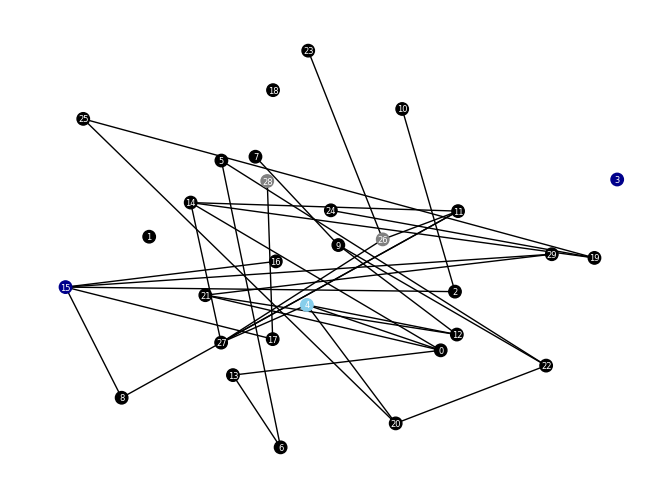

rewiring to a random susceptible node
34
Transitivity: 0.1791045


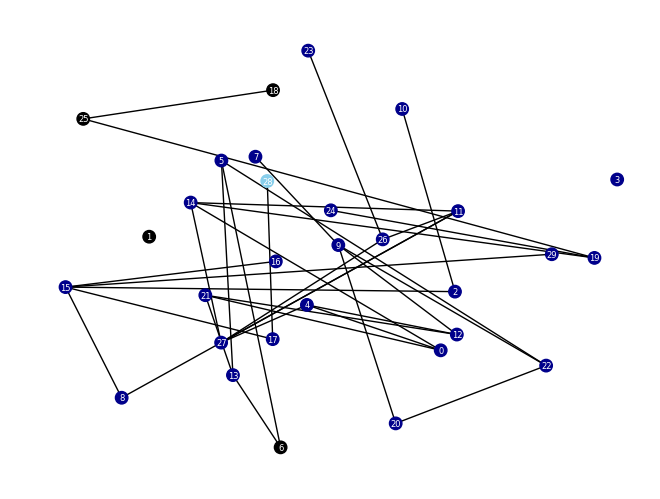

In [416]:
beta_u = 0.4
beta_a = beta_u / 5
alpha = 0.1 
infection_period = 10 
gamma = 0.1
eta = .8
SISModel = TwoLayerNetwork(30, 3, beta_a, beta_u, alpha, infection_period, gamma, eta, overlap_percentage=1, initial_infected_ratio=.1, intial_aware_ratio=.1)

pos = nx.random_layout(SISModel.get_network("physical"), seed=123)
nx.number_of_isolates(SISModel.get_network("physical"))

print(SISModel.get_network("physical").number_of_edges())
print(f"Transitivity: {nx.transitivity(SISModel.get_network('physical')):.7f}")
color_map = []
for node in SISModel.nodes:
    if node.state_awareness == 1 and node.state_disease == 1:
        color_map.append('skyblue')
    elif node.state_awareness == 0 and node.state_disease == 1:
        color_map.append('darkblue')
    elif node.state_awareness == 1 and node.state_disease == 0:
        color_map.append('gray')
    else: 
        color_map.append('black')
nx.draw(SISModel.get_network("physical"), pos=pos, with_labels = True, node_size = 80, node_color = color_map, font_size = 6, font_color='white')
plt.show()

for t in range(10):
    SISModel.update_one_round()
    
print(SISModel.get_network("physical").number_of_edges())
print(f"Transitivity: {nx.transitivity(SISModel.get_network('physical')):.7f}")
color_map = []
for node in SISModel.nodes:
    if node.state_awareness == 1 and node.state_disease == 1:
        color_map.append('skyblue')
    elif node.state_awareness == 0 and node.state_disease == 1:
        color_map.append('darkblue')
    elif node.state_awareness == 1 and node.state_disease == 0:
        color_map.append('gray')
    else: 
        color_map.append('black')  
nx.draw(SISModel.get_network("physical"), pos=pos, with_labels = True, node_size = 80, node_color = color_map, font_size = 6, font_color='white')
plt.show()

In [677]:
random.seed(123)
np.random.seed(123)

N = 1000
k = 5 # average degree
beta_u = 0.8 # transmission probability for unaware nodes
beta_a = beta_u / 10 # transmission probability for aware nodes
alpha = 0.1 # recovery probability 
infection_period = 50 # number of time steps before a node can recover
gamma = 0.8 # a susceptible individual will break each edge with an infected neighbor at a probability of gamma
eta = 0.8 # when rewiring, the new link to a susceptible node at a distance of two is made with probability eta.

SISModel = TwoLayerNetwork(N, k, beta_a, beta_u, alpha, infection_period, gamma, eta, initial_infected_ratio=0.05, intial_aware_ratio=0.01)

print(f"Physical network: {SISModel.get_network('physical').number_of_edges()} edges")
print(f"Virtual network: {SISModel.get_network('virtual').number_of_edges()} edges")
print(f"The number of isolated nodes: {nx.number_of_isolates(SISModel.get_network('physical'))}")
print(f"Infection number: {SISModel.count_infected()}")
print(f"Awareness number: {SISModel.count_aware()}")
print(f"Clustering coefficient: {nx.average_clustering(SISModel.get_network('physical')):.5f}")
print(f"Transitivity: {nx.transitivity(SISModel.get_network('physical')):.5f}")
print('-'*30)

# Run the simulation over time
time_steps = 3000

infection_counts = [SISModel.count_infected()]
awreness_counts = [SISModel.count_aware()]
for t in range(time_steps):
    # Update the health state 
    SISModel.update_one_round()
    
    # Track the number of infected individuals
    infection_counts.append(SISModel.count_infected())
    awreness_counts.append(SISModel.count_aware())

print(f"Physical network: {SISModel.get_network('physical').number_of_edges()} edges")
print(f"Virtual network: {SISModel.get_network('virtual').number_of_edges()} edges")
print(f"The number of isolated nodes: {nx.number_of_isolates(SISModel.get_network('physical'))}")
print(f"Infection number: {SISModel.count_infected()}")
print(f"Awareness number: {SISModel.count_aware()}")
print(f"Clustering coefficient: {nx.average_clustering(SISModel.get_network('physical')):.5f}")
print(f"Transitivity: {nx.transitivity(SISModel.get_network('physical')):.5f}")
print(f"The number of rewired edge: {SISModel.rewiring_count}")

Physical network: 2453 edges
Virtual network: 2453 edges
The number of isolated nodes: 4
Infection number: 50
Awareness number: 10
Clustering coefficient: 0.00168
Transitivity: 0.00202
------------------------------
Physical network: 2453 edges
Virtual network: 2453 edges
The number of isolated nodes: 66
Infection number: 742
Awareness number: 823
Clustering coefficient: 0.16996
Transitivity: 0.15249
The number of rewired edge: 62058


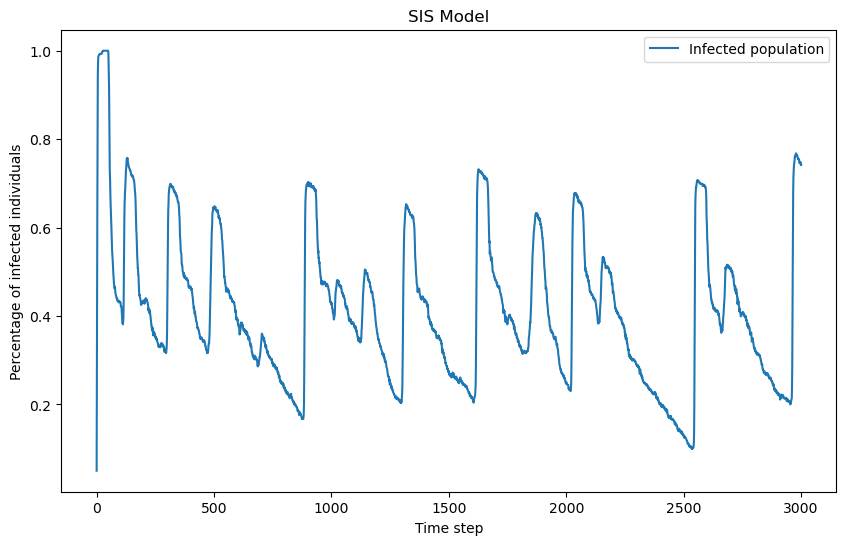

In [678]:
infection_proportion = np.array(infection_counts) / N

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps+1), infection_proportion, label='Infected population')
plt.xlabel('Time step')
plt.ylabel('Percentage of infected individuals')
plt.title('SIS Model')
plt.legend() 
plt.show()

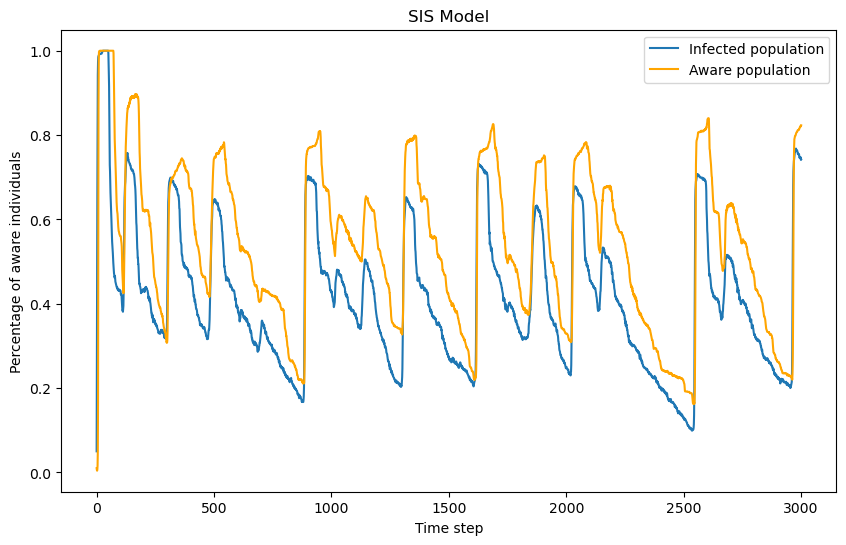

In [679]:
awreness_proportion = np.array(awreness_counts) / N

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps+1), infection_proportion, label='Infected population')
plt.plot(range(time_steps+1), awreness_proportion, label='Aware population', color='orange')
plt.xlabel('Time step')
plt.ylabel('Percentage of aware individuals')
plt.title('SIS Model')
plt.legend()
plt.show()

[254, 730, 335, 800, 346, 609, 245, 935, 853, 251] [254, 730, 335, 800, 346, 609, 245, 935, 853, 251]


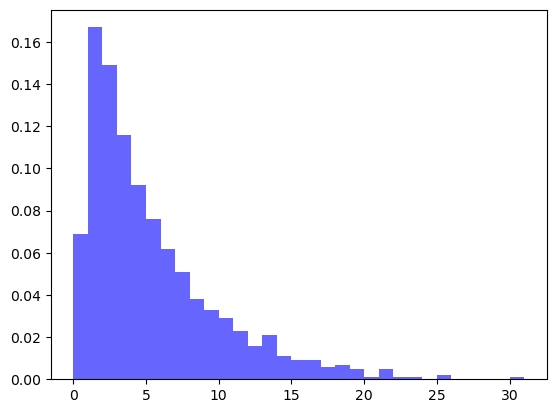

In [658]:
print(SISModel.nodes[1].get_physical_neighbors_id(), SISModel.nodes[1].get_virtual_neighbors_id())

degrees = [degree for _, degree in SISModel.get_network('physical').degree()]
plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
plt.show()

# degrees = [degree for _, degree in SISModel.get_network('virtual').degree()]
# plt.hist(degrees, bins=range(0, max(degrees) + 1), density=True, alpha=0.6, color='b', label="Empirical Degree Distribution")
# plt.show()